In [37]:
import torch
import sys
# add parent directory to the front of sys.path
sys.path.insert(0, '..')
import final_model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = final_model.Net().to(device)
model.load_state_dict(torch.load("../working_model.pth", weights_only=True))
model.eval()

Net(
  (sa1_module): SAModule(
    (conv): PointNetConv(local_nn=MLP(4, 64, 64, 128), global_nn=None)
  )
  (sa2_module): SAModule(
    (conv): PointNetConv(local_nn=MLP(131, 128, 128, 256), global_nn=None)
  )
  (sa3_module): GlobalSAModule(
    (nn): MLP(259, 256, 512, 1024)
  )
  (encode): MLP(1024, 512)
  (mlp_mu): MLP(512, 512)
  (mlp_logvar): MLP(512, 512)
  (sdf1): MLP(515, 256, 128)
  (sdf2): MLP(131, 64, 1)
)

In [39]:
# data set imports
import dataset_utils as du
from torch.utils.data import DataLoader, random_split

B = 1

# load dataset
dataset = du.SDFDataset("../cars995")

# create data loaders for training and validation sets
data_loader = DataLoader(dataset, batch_size=B, shuffle=True, num_workers=2, pin_memory=True)



In [40]:
def process_batch(batch, np_in=2048, np_q=15000):
    B, N, _ = batch.shape
    assert B == 1, "Batch size must be 1 for now."
    
    # # use surface points
    # surface_points = batch[batch[:, :, 3] == 0]
    idx = torch.randperm(N)[:np_in]
    pos = batch[:, idx, :3] # input positions (B, N, 3) -> (N, 3) # this is what fps expects
    x = batch[0, idx, 3].unsqueeze(-1)
    
    idx = torch.randperm(N)[:np_q]
    query_pos = batch[:, idx, :3] # query positions
    query_sdf = batch[:, idx, 3] # SDF values
    
    batch_vec = torch.zeros(np_in, dtype=torch.long) # batch vector for input points
    
    return x.to(device), pos.contiguous().squeeze(0).to(device), batch_vec.contiguous().squeeze(0).to(device), query_pos.squeeze(0).to(device), query_sdf.squeeze(0).to(device)

In [ ]:
all_z = []

for batch in data_loader:
    x, pos, batch, query_pos, query_sdf = process_batch(batch)

    x_encoded, _, _ = model.encoder(x, pos, batch)

    z, mu, logvar = model.vae(x_encoded)
    all_z.append(z.detach().cpu())

all_z = torch.cat(all_z, dim=0)
print(all_z.shape)

c:\Users\maxde\anaconda3\envs\final311\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

KeyboardInterrupt: 

In [42]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [43]:
print(all_z.shape)

torch.Size([995, 512])


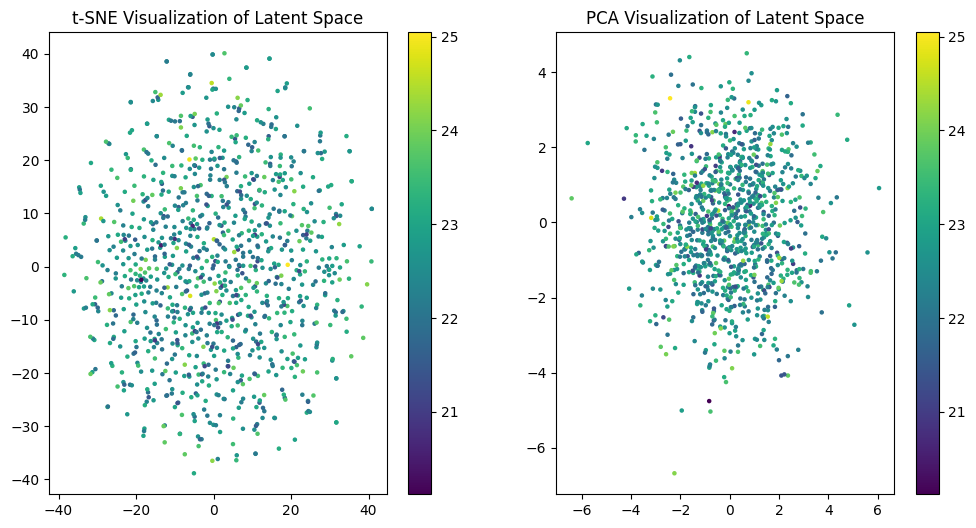

In [46]:
import numpy as np

# Visualize using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
z_tsne = tsne.fit_transform(all_z.detach().cpu())

# Visualize using PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(all_z.detach().cpu())

colors = np.linalg.norm(all_z.cpu().numpy(), axis=1)

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=colors, cmap='viridis', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of Latent Space')

plt.subplot(1, 2, 2)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=colors, cmap='viridis', s=5)
plt.colorbar()
plt.title('PCA Visualization of Latent Space')

plt.show()